<img src="assets/header_notebook.jpg" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:1.5vw; color:#5A7D9F; font-weight:bold;">
    <center>Ocean parameterizations in an idealized model using machine learning</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

[comment]: <> (Section)
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:1.5vw; color:#5A7D9F;">
    <center>Initialization</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

[comment]: <> (Description)
<p align="justify">
    In this section, one is able to load:
</p>

- All the librairies;

- Basic functions used throughout the entire notebook.

In [1]:
# -- Librairies --
import os
import sys
import glob
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
import pyqg
import fsspec
import xarray as xr
import pyqg.diagnostic_tools
import pyqg_parameterization_benchmarks.coarsening_ops as coarsening

from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm, trange
from pyqg_parameterization_benchmarks.utils import *
from pyqg.diagnostic_tools import calc_ispec as _calc_ispec
from pyqg_parameterization_benchmarks.neural_networks import FullyCNN
from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization
from pyqg_parameterization_benchmarks.online_metrics import diagnostic_differences

# Used to compute the power spectrum
calc_ispec = lambda *args, **kwargs: _calc_ispec(*args, averaging = False, truncate =False, **kwargs)

# You can use the magic function %matplotlib inline to enable the inline plotting, 
# where the plots/graphs will be displayed just below the cell where your plotting commands are written. 
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%load_ext autoreload
%autoreload 2

[comment]: <> (Section)
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:1.5vw; color:#5A7D9F;">
    <center>PYQG - Generating & Saving<\center>
    </b>
</p>
<hr style="color:#5A7D9F;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
</p>

- Generate a **high resolution** simulation from a quasi-geostrophic model (PYQG). 

- Afterwards, the corresponding **low resolution** simulation will be created using one of the operators (filtering and coarsening) created by L. Zanne & Al.. 

- Finally, the datasets will be **saved onto the hard drive**. 

<p align="justify">
    <b>Note</b>: Eddies and Jets simulation are the exact one used by L. Zanne & Al. in their paper.
</p>

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>Simulation type</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">
<table style="width: 100%;" border="1">
	<tbody>
		<tr>
			<td style="width: 15%;" align="center"><b>INDEX</b></td>
			<td style="width: 13%;" align="center">0</td>
			<td style="width: 13%;" align="center">1</td>
			<td style="width: 15%;" align="center">2</td>
			<td style="width: 15%;" align="center">3</td>
			<td style="width: 16%;" align="center">4</td>
			<td style="width: 18%;" align="center">5</td>
		</tr>
		<tr>
			<td style="width: 15%;"align="center"><b>TYPE</b></td>
			<td style="width: 13%;" align="center">Eddies</td>
			<td style="width: 13%;" align="center">Jets  </td>
			<td style="width: 15%;" align="center">Eddies (Debug)</td>
			<td style="width: 15%;" align="center">Jets   (Debug)</td>
			<td style="width: 16%;" align="center">Eddies (Random)</td>
			<td style="width: 18%;" align="center">Jets (Random)</td>
		</tr>
	</tbody>
</table>

<br>

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>Parameters</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">
<table style="width: 100%;" border="1">
	<tbody>
		<tr style="height: 21px;">
			<td style="width: 16%;" align="center"><b>PARAMETERS</b></td>
			<td style="width: 12%;" align="center">nx</td>
			<td style="width: 10%;" align="center">dt</td>
			<td style="width: 12%;" align="center">tmax</td>
			<td style="width: 12%;" align="center">tavestart</td>
			<td style="width: 12%;" align="center">rek</td>
			<td style="width: 12%;" align="center">Δ</td>
			<td style="width: 14%;" align="center">β</td>
		</tr>
		<tr style="height: 21.5px;">
			<td style="width: 16%;" align="center"><b>DESCRIPTION</b></td>
			<td style="width: 12%;" align="center">Number of real space grid points in the x directions</td>
			<td style="width: 10%;" align="center">Numerical timestep (in hours)</td>
			<td style="width: 12%;" align="center">Total time of integration (in years)</td>
			<td style="width: 12%;" align="center">Start time for averaging (in years)</td>
			<td style="width: 12%;" align="center">Linear drag in lower layer</td>
			<td style="width: 12%;" align="center">Layer thickness ratio (H1/H2)</td>
			<td style="width: 14%;" align="center">Gradient of coriolis parameter.</td>
		</tr>
		<tr style="height: 21.5px;">
			<td style="width: 16%;" align="center"><b>EDDIES</b></td>
			<td style="width: 12%;" align="center">256</td>
			<td style="width: 10%;" align="center">1</td>
			<td style="width: 12%;" align="center">10</td>
			<td style="width: 12%;" align="center">5</td>
			<td style="width: 12%;" align="center">5.789e-7</td>
			<td style="width: 12%;" align="center">0.25</td>
			<td style="width: 14%;" align="center">1.5 * 1e-11</td>
		</tr>
		<tr style="height: 21px;">
			<td style="width: 16%;" align="center"><b>JETS</b></td>
			<td style="width: 12%;" align="center">256</td>
			<td style="width: 10%;" align="center">1</td>
			<td style="width: 12%;" align="center">10</td>
			<td style="width: 12%;" align="center">5</td>
			<td style="width: 12%;" align="center">7e-08</td>
			<td style="width: 12%;" align="center">0.1</td>
			<td style="width: 14%;" align="center">1e-11</td>
		</tr>
		<tr style="height: 21.5px;">
			<td style="width: 16%;" align="center"><b>EDDIES (Debug)</b></td>
			<td style="width: 12%;" align="center">256</td>
			<td style="width: 10%;" align="center">1</td>
			<td style="width: 12%;" align="center">2</td>
			<td style="width: 12%;" align="center">1</td>
			<td style="width: 12%;" align="center">5.789e-7</td>
			<td style="width: 12%;" align="center">0.25</td>
			<td style="width: 14%;" align="center">1.5 * 1e-11</td>
		</tr>
		<tr style="height: 21px;">
			<td style="width: 16%;" align="center"><b>JETS (Debug)</b></td>
			<td style="width: 12%;" align="center">256</td>
			<td style="width: 10%;" align="center">1</td>
			<td style="width: 12%;" align="center">2</td>
			<td style="width: 12%;" align="center">1</td>
			<td style="width: 12%;" align="center">7e-08</td>
			<td style="width: 12%;" align="center">0.1</td>
			<td style="width: 14%;" align="center">1e-11</td>
		</tr>
		<tr style="height: 21.5px;">
			<td style="width: 16%;" align="center"><b>EDDIES (Random)</b></td>
			<td style="width: 12%;" align="center">256</td>
			<td style="width: 10%;" align="center">1</td>
			<td style="width: 12%;" align="center">10</td>
			<td style="width: 12%;" align="center">5</td>
			<td style="width: 12%;" align="center">[5.7, 5.9] * 1e-7</td>
			<td style="width: 12%;" align="center">0.25</td>
			<td style="width: 14%;" align="center">[1.45, 1.55] * 1e-11</td>
		</tr>
		<tr style="height: 21px;">
			<td style="width: 16%;" align="center"><b>JETS (Random)</b></td>
			<td style="width: 12%;" align="center">256</td>
			<td style="width: 10%;" align="center">1</td>
			<td style="width: 12%;" align="center">10</td>
			<td style="width: 12%;" align="center">5</td>
			<td style="width: 12%;" align="center">[6.9, 7.1] * 1e-8</td>
			<td style="width: 12%;" align="center">0.1</td>
			<td style="width: 14%;" align="center">[0.95, 1.05] * 1e-11</td>
		</tr>
	</tbody>
</table>

<br>

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>Coarsening operators</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">
<table style="width: 100%;" border="1">
	<tbody>
		<tr>
			<td style="width: 10%;" align="center"><b>OPERATOR</b></td>
			<td style="width: 15%;" align="center">&nbsp;1</td>
			<td style="width: 15%;" align="center">&nbsp;2</td>
			<td style="width: 17%;" align="center">3</td>
		</tr>
		<tr>
			<td style="width: 10%;"align="center"><b>DESCRIPTION</b></td>
			<td style="width: 15%;"align="center">Spectral Truncation, Sharp Filter</td>
			<td style="width: 15%;"align="center">Spectral Truncation, Gaussian Filter</td>
			<td style="width: 17%;"align="center">GCM Filter, Averaging and Coarsening</td>
		</tr>
	</tbody>
</table>
<hr style="color:#5A7D9F; width: 100%;" align="left">

In [ ]:
# Name of the folder used to save the datasets (../datasets/save_folder)
save_folder = "test"

# Simulation type to use to generate the high resolution data
simulation_type = 2

# Frequency to save the results (Ex: if sampling = 1, each hour the data is saved)
sampling_frequency = 500

# Operator to apply on the high resolution data
operator_index = 1

# Size of the dataset that will be used as training data
train_size = 0.7

# Number of threads to use by PYQG
number_threads = 2

# Determine if the high resolution training set should be saved entirely or just the last sample 
save_HR_train = False

In [11]:
# -- Functions -- 
#
def getPath(folder_name, loading = False):
    """
    Used to determine the path to the results' folder for the FCNN
    """
    # Count number of already existing folders in the model folder
    nb_files = len(glob.glob("../models/*"))

    # Creation of a non-existing folder name
    return f"../models/{folder_name}/" if loading else f"../models/{folder_name}_{nb_files}/"

def config_for(model):
    """
    Return the parameters needed to initialize a new pyqg.QGModel, except for nx and ny.
    """
    config = dict(H1 = model.Hi[0])
    for prop in ['L', 'W', 'dt', 'rek', 'g', 'beta', 'delta','U1', 'U2', 'rd']:
        config[prop] = getattr(model, prop)
    return config

def train_test_split_xarray(dataset, train_size = 0.7):
    """
    Split an xarray dataset into a training and test datasets
    """
    # Retreiving the size of the time dimension of the xarray
    size = dataset.dims["time"]

    # Computing indexes for training and testing sets
    index_train_start = 0
    index_train_end   = int(size * train_size)
    index_test_start  = index_train_end + 1
    index_test_end    = size - 1

    # Creating slicing vectors
    train_indexes = list(np.linspace(index_train_start, index_train_end, num = index_train_end + 1,               dtype = int))
    test_indexes  = list(np.linspace(index_test_start,  index_test_end , num = index_test_end - index_test_start, dtype = int))

    # Creation of the datasets
    dataset_train = dataset.isel(time = train_indexes)
    dataset_test  = dataset.isel(time = test_indexes)

    return dataset_train, dataset_test

def add_Forcing_Fluxes(coarsened_model):
    """
    From a coarsened model (result of coarsening operator), retreives the dataset 
    containing PYQG variables as well as the subgrid forcing and fluxes terms.
    """
    # Initial dataset (everything will be added to it)
    dataset_init = coarsened_model.m2.to_dataset().copy(deep = True)
    
    # Computing Subgrid Variables
    dqdt_bar, dqbar_dt, q_tot = coarsened_model.q_forcing_total
    q_sfor                    = coarsened_model.subgrid_forcing("q")
    u_sfor                    = coarsened_model.subgrid_forcing("u")
    v_sfor                    = coarsened_model.subgrid_forcing("v")
    uq_sf, vq_sf              = coarsened_model.subgrid_fluxes("q")
    uu_sf, vu_sf              = coarsened_model.subgrid_fluxes("u")
    uv_sf, vv_sf              = coarsened_model.subgrid_fluxes("v")

    # Creation of dataset with missing values
    missing_values = {
                        "q_forcing_total"   : (("lev", "x", "y"), q_tot),
                        "dqdt_bar"          : (("lev", "x", "y"), dqdt_bar),
                        "dqbar_dt"          : (("lev", "x", "y"), dqbar_dt),
                        "q_subgrid_forcing" : (("lev", "x", "y"), q_sfor),
                        "u_subgrid_forcing" : (("lev", "x", "y"), u_sfor),
                        "v_subgrid_forcing" : (("lev", "x", "y"), v_sfor),
                        "uq_subgrid_flux"   : (("lev", "x", "y"), uq_sf),
                        "vq_subgrid_flux"   : (("lev", "x", "y"), vq_sf),
                        "uu_subgrid_flux"   : (("lev", "x", "y"), uu_sf),
                        "vv_subgrid_flux"   : (("lev", "x", "y"), vv_sf),
                        "uv_subgrid_flux"   : (("lev", "x", "y"), uv_sf)}

    dataset_forcing_fluxes = xr.Dataset(missing_values)

    # Merging all the results    
    return xr.merge([dataset_init, dataset_forcing_fluxes])

def generateData(model_HR, coarsening_index = 1, sampling_freq = 1000, low_res_nx = 64, number_threads = 1):
    """
    Used to generate datasets corresponding to a: 
    - High resolution          (= HR,  nx = 256)
    - Augmented low resolution (= ALR, nx = 64 ) with q coming from HR after coarsening and filtering
    - Low resolution           (= LR,  nx = 64 )
    """
    snapshots_HIGH_RESOLUTION, snapshots_AUG_LOW_RESOLUTION, snapshots_LOW_RESOLUTION = list(), list(), list()

    # Stores the different models
    model_ALR = 1
    model_LR  = pyqg.QGModel(nx = low_res_nx, ntd = number_threads, **config_for(model_HR))
    
    #---------------------------------------
    #         Running the simulation 
    #---------------------------------------
    while model_HR.t < model_HR.tmax:
    
        # Computing next step of simulation
        model_HR._step_forward()
        model_LR._step_forward()
        
        # Sampling of data
        if model_HR.tc % sampling_freq == 0:

            # Creation of the coarsened data
            if coarsening_index   == 1:
                model_ALR = coarsening.Operator1(model_HR, low_res_nx = low_res_nx) # Spectral truncation + sharp filter
            elif coarsening_index == 2:
                model_ALR = coarsening.Operator2(model_HR, low_res_nx = low_res_nx) # Spectral truncation + sharp filter
            else:
                model_ALR = coarsening.Operator3(model_HR, low_res_nx = low_res_nx) # GCM-Filters + real-space coarsening

            # Saving everything
            snapshots_HIGH_RESOLUTION.append(   model_HR.to_dataset().copy(deep = True))
            snapshots_LOW_RESOLUTION.append(    model_LR.to_dataset().copy(deep = True))
            snapshots_AUG_LOW_RESOLUTION.append(add_Forcing_Fluxes(model_ALR))

    #---------------------------------------
    #            Xarray creations
    #---------------------------------------
    # Concatenation of all the results into a big dataset
    ds_HR  = xr.concat(snapshots_HIGH_RESOLUTION,     dim = 'time')
    ds_ALR = xr.concat(snapshots_AUG_LOW_RESOLUTION,  dim = 'time')
    ds_LR  = xr.concat(snapshots_LOW_RESOLUTION,      dim = 'time')

    # Diagnostics get dropped by this procedure since they're only present for part of the timeseries; 
    # resolve this by saving the most recent diagnostics (they're already time-averaged so this is ok)
    for k, v in snapshots_HIGH_RESOLUTION[-1].variables.items():
        if k not in ds_HR:
            ds_HR[k] = v.isel(time = -1)

    for k,v in snapshots_AUG_LOW_RESOLUTION[-1].variables.items():
        if k not in ds_ALR:
            ds_ALR[k] = v.isel(time = -1)
            
    for k,v in snapshots_LOW_RESOLUTION[-1].variables.items():
        if k not in ds_LR:
            ds_LR[k] = v.isel(time = -1)

    # Drop complex variables since they're redundant and can't be saved
    complex_vars = [k for k,v in ds_HR.variables.items() if np.iscomplexobj(v)]
    ds_HR = ds_HR.drop_vars(complex_vars)
    
    complex_vars = [k for k,v in ds_ALR.variables.items() if np.iscomplexobj(v)]
    ds_ALR = ds_ALR.drop_vars(complex_vars)

    complex_vars = [k for k,v in ds_LR.variables.items() if np.iscomplexobj(v)]
    ds_LR = ds_LR.drop_vars(complex_vars)

    return ds_HR, ds_ALR, ds_LR, model_LR

In [ ]:
# -- Generating --
#
# Definition of the parameters for each possible simulation type
nx        = [256        , 256   , 256        , 256  ,  256, 256]
dt        = [1          , 1     , 1          , 1    ,    1,   1]
tmax      = [10         , 10    , 0.5        , 0.5  ,   10,  10] 
tavestart = [5          , 5     , 1          , 1    ,    5,   5]
rek       = [5.789e-7   , 7e-08 , 5.789e-7   , 7e-08,   -1,  -1]
delta     = [0.25       , 0.1   , 0.25       , 0.1  , 0.25, 0.1]
beta      = [1.5 * 1e-11, 1e-11 , 1.5 * 1e-11, 1e-11,   -1,  -1]

# Radom parameter values
rek_random  = random.uniform(5.7, 5.9)   * 1e-7  if simulation_type < 5 else \
              random.uniform(6.9, 7.1)   * 1e-8

beta_random = random.uniform(1.45, 1.55) * 1e-11 if simulation_type < 5 else \
              random.uniform(0.95, 1.05) * 1e-11

# Dictionnary of simulation parameters (Conversion to seconds embedded)
simulation_parameters              = {}
simulation_parameters['nx']        = nx       [simulation_type]
simulation_parameters['dt']        = dt       [simulation_type] * 60 * 60
simulation_parameters['tmax']      = tmax     [simulation_type] * 24 * 60 * 60 * 360
simulation_parameters['tavestart'] = tavestart[simulation_type] * 24 * 60 * 60 * 360
simulation_parameters['rek']       = rek      [simulation_type] if simulation_type < 4 else rek_random
simulation_parameters['delta']     = delta    [simulation_type]
simulation_parameters['beta']      = beta     [simulation_type] if simulation_type < 4 else beta_random

# Creation of a PYQG model with corresponding parameters
model_HIGH_RESOLUTION = pyqg.QGModel(ntd = number_threads, **simulation_parameters)

# Generation of all the datasets
dataset_HR, dataset_ALR, dataset_LR, model_LOW_RESOLUTION = generateData(model_HIGH_RESOLUTION, 
                                                                         coarsening_index = operator_index, 
                                                                         sampling_freq    = sampling_frequency,
                                                                         number_threads   = number_threads)
                                                            

In [ ]:
# -- Saving --
#
# Complete path to saving folder
saving_path = "../datasets/" + save_folder

# Checks if the saving folder exists, if not, creates it
if not os.path.exists(saving_path):
   os.makedirs(saving_path)

# Creation of training and test sets
train_HR,  test_HR  = train_test_split_xarray(dataset_HR,  train_size = train_size)
train_ALR, test_ALR = train_test_split_xarray(dataset_ALR, train_size = train_size)
train_LR,  test_LR  = train_test_split_xarray(dataset_LR,  train_size = train_size)

# Saving everything to special format (recommended by xarray doccumentation)
train_LR.to_netcdf( saving_path + "/train_LR.nc")
train_ALR.to_netcdf(saving_path + "/train_ALR.nc" )
test_HR.to_netcdf(  saving_path + "/test_HR.nc" )
test_LR.to_netcdf(  saving_path + "/test_LR.nc" )
test_ALR.to_netcdf( saving_path + "/test_ALR.nc" )

# In order to simply observe what is inside the training set, the last sample 
# is uniquely saved (in order to save space). However, one has still the possibility 
# to save the entire dataset if needed.
train_HR.to_netcdf(saving_path + "/train_HR.nc") if save_HR_train == True else \
   train_HR.isel(time = [-1]).copy(deep = True).to_netcdf(saving_path + "/train_HR.nc")

[comment]: <> (Section)
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:1.5vw; color:#5A7D9F;">
    <center>PYQG - Loading<\center>
    </b>
</p>
<hr style="color:#5A7D9F;">


[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
</p>

- **Load** a **high resolution** simulation and its corresponding **low resolution** dataset saved on a hard drive.

- Observe the distribution of quantities such as **energy** and **enstrophy**.

**Energy budget (should sum to 0):**
- `KEflux`: how kinetic energy is being transferred across lengthscales
- `APEflux`: how available potential energy is being transferred across lengthscales
- `APEgenspec`: how much new available potential energy is being generated at each scale
- `KEfrictionspec`: how much energy is being lost to bottom drag at each lengthscale
- `Dissspec`: how much energy is being lost due to numerical dissipation at each lengthscale

**Enstrophy budget (should sum to 0):**
- `ENSflux`: how enstrophy is being transferred across lengthscales
- `ENSgenspec`: how much new enstrophy is being generated
- `ENSfrictionspec`: how much enstrophy is lost to bottom drag
- `ENSDissspec`: how much enstrophy is lost to numerical dissipation

In [6]:
# Define the folder from which to load the datasets
loading_folder_data = ["eddies_1", "eddies_2", "eddies_3"]#, "eddies_4", "eddies_5"]


In [ ]:
# -- Loading all the datasets and concatenation--
#
# Creation of the different paths
path_train_HR, path_test_HR, path_train_LR,\
path_test_LR, path_train_ALR, path_test_ALR = list(), list(), list(), list(), list(), list()

for p in loading_folder_data:
    path_train_HR.append( "../datasets/" + p + "/train_HR.nc")
    path_train_LR.append( "../datasets/" + p + "/train_LR.nc")
    path_train_ALR.append("../datasets/" + p + "/train_ALR.nc")
    path_test_HR.append(  "../datasets/" + p + "/test_HR.nc")
    path_test_LR.append(  "../datasets/" + p + "/test_LR.nc")
    path_test_ALR.append( "../datasets/" + p + "/test_ALR.nc")

# Loading initial dataset
train_HR  = xr.load_dataset(path_train_HR[0] )
train_LR  = xr.load_dataset(path_train_LR[0] )
train_ALR = xr.load_dataset(path_train_ALR[0])
# test_HR   = xr.load_dataset(path_test_HR[0]  )
test_LR   = xr.load_dataset(path_test_LR[0]  )
test_ALR  = xr.load_dataset(path_test_ALR[0] )

# Concatenation of the other datasets
for p in range(1, len(loading_folder_data)):
    print(path_train_HR[p])
    train_HR  = xr.concat([train_HR , xr.load_dataset(path_train_HR[p])], dim = "time")
    train_LR  = xr.concat([train_LR , xr.load_dataset(path_train_LR[p])], dim = "time")
    train_ALR = xr.concat([train_ALR, xr.load_dataset(path_train_ALR[p])], dim = "time")
    # test_HR   = xr.concat([test_HR  , xr.load_dataset(path_test_HR[p])], dim = "time")
    test_LR   = xr.concat([test_LR  , xr.load_dataset(path_test_LR[p])], dim = "time")
    test_ALR  = xr.concat([test_ALR , xr.load_dataset(path_test_ALR[p])], dim = "time")

# Displaying information regarding number of samples
print("-----------------")
print("     Datasets    ")
print("-----------------")
for d in loading_folder_data:
    print(f"- {d}")
    
print("\n-----------------")
print("Number of samples")
print("-----------------")
print("Train HR  = " + str(train_HR.dims["time"] ))
print("Train LR  = " + str(train_LR.dims["time"] ))
print("Train ALR = " + str(train_ALR.dims["time"]))
# print("Test  HR  = " + str(test_HR.dims["time"]  ))
print("Test  LR  = " + str(test_LR.dims["time"]  ))
print("Test  ALR = " + str(test_ALR.dims["time"] ))
print("\nTotal : "   + str(train_ALR.dims["time"] + test_ALR.dims["time"]))

../datasets/eddies_5/train_HR.nc


In [ ]:
print(train_ALR)

[comment]: <> (Section)
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:1.5vw; color:#5A7D9F;">
    <center>PYQG - Dataset exploration (high and low resolution)</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to observe graphically one of the following variables:
</p>

- **State variables**

<table style="width: 100%;">
    <tbody>
    <tr>
            <td width="12%;" align="center">q</td>
            <td width="15%;" align="center">u</td>
            <td width="15%;" align="center">v</td>
            <td width="15%;" align="center">ufull</td>
            <td width="15%;" align="center">vfull</td>
            <td width="23%;" align="center">streamfunction - Ψ (NW)</td>
        </tr>
        <tr>
            <td align="center">Potential vorcitity</td>
            <td align="center">x-velocity relative to the background flow</td>
            <td align="center">y-velocity relative to the background flow</td>
            <td align="center">x-velocity with the background flow </td>
            <td align="center">y-velocity with the background flow </td>
            <td align="center">A particular case of a vector potential of velocity , related to velocity by the equality</td>
        </tr>
    </tbody>
</table>

- **Subgrid forcing variables**

| Forcing | q | u | v |
|---| :----: | :----: | :----: |
| Equation | $S_q \equiv \overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$ | $S_u \equiv \overline{(\mathbf{u} \cdot \nabla)u} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{u}$ | $S_v \equiv \overline{(\mathbf{u} \cdot \nabla)v} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{v}$ |

<br/>

- **Subgrid flux variables**

| Flux | uq | vq | uu | vv | uv |
|---|:----:|:----:|:----:|:----:|:----:|
| Equations | $\phi_{uq} \equiv \overline{uq} - \bar{u}\bar{q}$ | $\phi_{vq} \equiv \overline{vq} - \bar{v}\bar{q}$ | $\phi_{uu} \equiv \overline{u^2} - \bar{u}^2$ | $\phi_{vv} \equiv \overline{v^2} - \bar{v}^2$ | $\phi_{uv} \equiv \overline{uv} - \bar{u}\bar{v}$ |

<br/>

- **Other variables**

| Flux | dqdt_bar | dqbar_dt |
|---|:----:|:----:|
| Information |  PV tendency from the high-resolution model, filtered and coarsened to low resolution | PV tendency from the low-resolution model,  initialized at $\overline{q}$|


<br/>

- *Note*

	- $\nabla \cdot \langle\phi_{uq}, \phi_{vq}\rangle = S_q$;

	- $\nabla \cdot \langle\phi_{uu}, \phi_{uv}\rangle = S_u$ and $\nabla \cdot \langle\phi_{uv}, \phi_{vv}\rangle = S_v$;

    - dqdt_bar - dqbar_dt can be an alternative to $S_q$ (it's very similar, except it also accounts for numerical dissipation).

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
    <b style="font-size:1vw;">
        <center>Functions</center>
    </b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">

In [ ]:
# -- Functions (State variables) --
#
# Allows to display easily an image (from coarsening notebook)
def imshow(arr, vlim = 3e-5):
    plt.xticks([]); plt.yticks([])
    return plt.imshow(arr, vmin = -vlim, vmax = vlim, cmap = 'bwr', interpolation = 'none')

# Used to plot easily a state variable
def plotStateVariable(high_res, low_res, state_variable = "q", save_path = ""):

    # Text for the caption
    caption = ["Upper Level : z = 1", "Lower Level : z = 2"]

    # Looping over the levels
    for l in range(2):

        # Initialization of the plot
        fig = plt.figure(figsize=(21, 6))

        # Plotting the state variables (Note: in the coarsening class, the original high resolution model is stored in m1 !)
        if state_variable == "q":

            # High resolution
            plt.subplot(1, 2, 1)
            high_res.q.isel(lev = l, time = -1).plot()

            # Low resolution
            plt.subplot(1, 2, 2)
            low_res.q.isel(lev = l, time = -1).plot()

            # Adding a caption to the plot
            fig.text(0.45, -0.1, f"$Figure$: Representation of the potential vorticity q for the high resolution (left) and low resolution simulations (right) - {caption[l]}", ha = 'center')

        elif state_variable == "u":

            # High resolution
            plt.subplot(1, 2, 1)
            high_res.u.isel(lev = l, time = -1).plot()

            # Low resolution
            plt.subplot(1, 2, 2)
            low_res.u.isel(lev = l, time = -1).plot()

            # Adding a caption to the plot
            fig.text(0.45, -0.1, f"$Figure$: Representation of the horizontal velocity u for the high resolution (left) and low resolution simulations (right) - {caption[l]}", ha = 'center')

        elif state_variable == "v":
                    
            # High resolution
            plt.subplot(1, 2, 1)
            high_res.v.isel(lev = l, time = -1).plot()

            # Low resolution
            plt.subplot(1, 2, 2)
            low_res.v.isel(lev = l, time = -1).plot()

            # Adding a caption to the plot
            fig.text(0.45, -0.1, f"$Figure$: Representation of the vertical velocity y for the high resolution (left) and low resolution simulations (right) - {caption[l]}", ha = 'center')

        elif state_variable == "ufull":
                    
            # High resolution
            plt.subplot(1, 2, 1)
            high_res.ufull.isel(lev = l, time = -1).plot()

            # Low resolution
            plt.subplot(1, 2, 2)
            low_res.ufull.isel(lev = l, time = -1).plot()

            # Adding a caption to the plot
            fig.text(0.45, -0.1, f"$Figure$: Representation of the horizontal velocity u with background flow for the high resolution (left) and low resolution simulations (right) - {caption[l]}", ha = 'center')


        elif state_variable == "vfull":
                    
            # High resolution
            plt.subplot(1, 2, 1)
            high_res.vfull.isel(lev = l, time = -1).plot()

            # Low resolution
            plt.subplot(1, 2, 2)
            low_res.vfull.isel(lev = l, time = -1).plot()

            # Adding a caption to the plot
            fig.text(0.45, -0.1, f"$Figure$: Representation of the vertical velocity v with background flow for the high resolution (left) and low resolution simulations (right) - {caption[l]}", ha = 'center')


        elif state_variable == "streamfunction":
                    
            # High resolution
            plt.subplot(1, 2, 1)
            high_res.streamfunction.isel(lev = l, time = -1).plot()

            # Low resolution
            plt.subplot(1, 2, 2)
            low_res.streamfunction.isel(lev = l, time = -1).plot()

            # Adding a caption to the plot
            fig.text(0.45, -0.1, f"$Figure$: Representation of the streamfunction for the high resolution (left) and low resolution simulations (right) - {caption[l]}", ha = 'center')

        if save_path not in [""]:

            # Complete path to save the figure
            save_path_complete = f"../datasets/{save_path}/state_variables/{state_variable}"

            # Check if image folder exists
            if not os.path.exists(save_path_complete):
                os.makedirs(save_path_complete)

            # Save the figure
            fig.savefig(save_path_complete + f"/{state_variable}_{l}.png")


In [ ]:
# -- Functions (Subgrid variables) --
#
# Allows to display easily an image (from coarsening notebook, version 2 with axis label)
def imshow_2(arr, vlim = 3e-5):
    plt.xticks([]); plt.yticks([])
    plt.xlabel("Grid coordinates ($\mathbb{R}$) - $x$ direction")
    return plt.imshow(arr, vmin = -vlim, vmax = vlim, cmap = 'bwr', interpolation = 'none')

def plotPowerSpectrum(model_lr, forcing_variable = "q", save_path = ""):

        # Power spectrum of subgrid potential vorticity
        fig = plt.figure(figsize=(15, 4))
        plt.title(f"Power spectrum of $S_{forcing_variable}$")

        # Retreiving results
        Sq = model_lr.subgrid_forcing('q')

        # Applying fast fourier transform
        line = plt.loglog(*calc_ispec(model_lr.m2, np.abs(model_lr.m2.fft(Sq))[0]**2), label = "Low Resolution")
        plt.loglog(*calc_ispec(model_lr.m2, np.abs(model_lr.m2.fft(Sq))[1]**2), color=line[0]._color, ls='--', label='Low Resolution - (Lower bound)')
        plt.legend(ncol=3)
        plt.grid()
        plt.ylabel("Power spectrum")
        plt.xlabel("Isotropic wavenumber - $\lambda$")

        if save_path not in [""]:

            # Complete path to save the figure
            save_path_complete = f"../datasets/{save_path}/subgrid_forcing/power_spectrum/{forcing_variable}"

            # Check if image folder exists
            if not os.path.exists(save_path_complete):
                os.makedirs(save_path_complete)

            # Save the figure
            fig.savefig(save_path_complete + f"/ps_{forcing_variable}.png")

def plotForcingVariable(model_lr, forcing_variable = "sq", save_path = ""):

    # Subgrid - Potential vorticity
    if forcing_variable == "sq":

        # Initialization of the figure
        fig = plt.figure(figsize=(22, 6))
        plt.subplot(1, 2, 1, title = '$S_{q_{total}}$')
        plt.ylabel("Grid coordinates ($\mathbb{R}$) - $y$ direction")

        # Total potential vorticity forcing term (Sq_tot)
        imshow_2(model_lr.q_forcing_total[0][0], 3e-11)

        # Subgrid potential vorticity term (Sq)
        plt.subplot(1, 2, 2, title = '$S_{q}$')
        im = imshow_2(model_lr.subgrid_forcing('q')[0], 3e-11)
        cb = fig.colorbar(im, ax = fig.axes, pad=0.15).set_label('$S_{q}$ [$s^{-2}$]')


    # Subgrid - Horizontal velocity
    if forcing_variable == "su":

        # Initialization of the figure
        fig = plt.figure(figsize=(22, 6))
        plt.plot(title = '$S_{u}$')
        plt.ylabel("Grid coordinates ($\mathbb{R}$) - $y$ direction")

        # Subgrid potential vorticity term (Sq)
        im = imshow_2(model_lr.subgrid_forcing('u')[0], 1.5e-7)
        cb = fig.colorbar(im, ax = fig.axes, pad=0.15).set_label('$S_{u}$ [$m\,s^{-2}$]')


    # Subgrid - Vorticity flux
    if forcing_variable == "flux":

        # Initialization of the figure
        fig = plt.figure(figsize=(22, 6))
        plt.subplot(1, 2, 1, title = '$\phi_{q_{u}}$')
        plt.ylabel("Grid coordinates ($\mathbb{R}$) - $y$ direction")

        # Retreiving fluxes
        uq, vq = model_lr.subgrid_fluxes('q')

        # Subgrid vorticity flux in horizontal direction
        imshow_2(uq[1], 1.5e-8)

        # Subgrid vorticity flux in vertical direction
        plt.subplot(1, 2, 2, title = '$\phi_{q_{v}}$')
        im = imshow_2(vq[1], 1.5e-7)
        cb = fig.colorbar(im, ax = fig.axes, pad=0.15).set_label('$\phi_{q}$ [$m\,s^{-2}$]')

    if save_path not in [""]:

        # Complete path to save the figure
        save_path_complete = f"../datasets/{save_path}/subgrid_forcing/forcing_variable/{forcing_variable}"

        # Check if image folder exists
        if not os.path.exists(save_path_complete):
            os.makedirs(save_path_complete)

        # Save the figure
        fig.savefig(save_path_complete + f"/fv_{forcing_variable}.png")

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>State variables</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">

In [ ]:
# -- Potential vorticity q -- 
plotStateVariable(train_HR, train_ALR, state_variable = "q", save_path = loading_folder_data)

In [ ]:
# -- Horizontal velocity u -- 
plotStateVariable(train_HR, train_ALR, state_variable = "u", save_path = loading_folder_data)

In [ ]:
# -- Vertical velocity v -- 
plotStateVariable(train_HR, train_ALR, state_variable = "v", save_path = loading_folder_data)

In [ ]:
# -- Horizontal velocity with background flow ufull -- 
plotStateVariable(train_HR, train_ALR, state_variable = "ufull", save_path = loading_folder_data)

In [ ]:
# -- Vertical velocity with background flow vfull -- 
plotStateVariable(train_HR, train_ALR, state_variable = "vfull", save_path = loading_folder_data)

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>Subgrid variables</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">

In [ ]:
# -- Potential vorticity --
try   : 
    model_LOW_RESOLUTION
except: 
    NameError: print("Attention : In order to display subgrid variables, you need the low resolution model !")
else  :
    plotPowerSpectrum(  model_LOW_RESOLUTION, forcing_variable = "q",  save_path = loading_folder_data)
    plotForcingVariable(model_LOW_RESOLUTION, forcing_variable = "sq", save_path = loading_folder_data)

In [ ]:
# -- Velocity --
try   : 
    model_LOW_RESOLUTION
except: 
    NameError: print("Attention : In order to display subgrid variables, you need the low resolution model !")
else  :
    plotPowerSpectrum(  model_LOW_RESOLUTION, forcing_variable = "u",  save_path = loading_folder_data)
    plotForcingVariable(model_LOW_RESOLUTION, forcing_variable = "su", save_path = loading_folder_data)

In [ ]:
# -- Vorticity flux --
try   : 
    model_LOW_RESOLUTION
except: 
    NameError: print("Attention : In order to display subgrid variables, you need the low resolution model !")
else  :
    plotForcingVariable(model_LOW_RESOLUTION, forcing_variable = "flux", save_path = loading_folder_data)

[comment]: <> (Section)
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:1.5vw; color:#5A7D9F;">
    <center>Fully Convolutional Neural Network (FCNN)</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
</p>
 
- Create a new fully convolutional neural network based on the class FCNN created by L. Zanne & Al;

- Train the network on the dataset created in the former section;

- Save it for later use.

In [9]:
# Define the name of the folder to store the resulting network
result_folder = "fcnn_q_q_subgrid_forcing_TEST"

In [13]:
# -- Training & Saving --
#
# Determine the complete path of the result folder
result_folder_path = getPath(result_folder)

# 
# Check if cuda is available
print("------------")
print("CUDA = " + str(torch.cuda.is_available()))
print("------------")

# Training the parameterization
FCNN_trained = FCNNParameterization.train_on(dataset    = train_ALR, 
                                             directory  = result_folder_path,
                                             inputs     = ['q'],
                                             targets    = ['q_subgrid_forcing'],
                                             num_epochs = 50, 
                                             zero_mean  = True, 
                                             padding    = 'circular')

------------
CUDA = True
------------
-----------------------------------------------
 Fully Convolutional neural network - Training 
-----------------------------------------------
---------------
 Model - z = 0 
---------------
Epoch :  1 / 50
[########################################] - 100.00 % | Loss (Training) = 0.5375 | Total time left : 0.00 s |  
Epoch :  2 / 50
[########################################] - 100.00 % | Loss (Training) = 0.2710 | Total time left : 468.46 s |  
Epoch :  3 / 50
[########################################] - 100.00 % | Loss (Training) = 0.2374 | Total time left : 458.07 s |  
Epoch :  4 / 50
[########################################] - 100.00 % | Loss (Training) = 0.2202 | Total time left : 448.86 s |  
Epoch :  5 / 50
[########################################] - 100.00 % | Loss (Training) = 0.2068 | Total time left : 439.97 s |  
Epoch :  6 / 50
[########################################] - 100.00 % | Loss (Training) = 0.1980 | Total time left : 431.0

[comment]: <> (Section)
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:1.5vw; color:#5A7D9F;">
    <center>FCCN - Parameterization evaluation (Offline & Online)</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
</p>
 
- **Load** a trained FCNN parameterization;

- Evaluate its **offline performances** on a test set, i.e. it's ability to **predict** accurately the **subgrid forcing terms**;

- Evaluate its **online performances** on a test set, i.e. it's ability to **create a ALRS** or in other words a simulation whose **results** are **close to** one obtained from a **high resolution simulation**.

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	Loading a trained network
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">

In [17]:
# Define the name of the folder that is used to load the neural network
loading_folder = "fcnn_q_q_subgrid_forcing_TEST_5"

# Define which target variable the network has been trained on (q_subgrid_forcing = 0 or q_forcing_total = 1)
target_var = 0

# Determine the complete path of the loading folder
loading_folder_path = getPath(loading_folder, loading = True)

# Loading the corresponding FCNN
FCNN_trained = FCNNParameterization(loading_folder_path)

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>Offline</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">
The two metrics used to evaluate the offline performances of the parameterization are:

- **Pearson correlation** ($\rho$) : where $\sigma$ denotes the empirical standard deviation of a quantity over the dataset. This quantity is between -1 and 1 and can remain high even when R2 is negative, e.g. if predictions are wrong by a large but consistent scaling factor. It's mathematical expression is:

<center>$\rho = \dfrac{\text{Cov}(S, \hat{S})}{\sigma_S \sigma_{\hat{S}}}$</center>

<br>

- **Coefficient of determination** ($R^2$) : which is 1 when predictions are perfect, 0 when predictions are no better than than always predicting the mean, and negative when worse than always predicting the mean. It's mathematical expression is:

<center>$R^2 = 1 - \dfrac{E[(S - \hat{S})^2]}{E[(S - E[S])^2]}$</center>

In [18]:
# -- Functions --
#
# Used to plot easily the results
def imshow(arr):
    plt.imshow(arr, vmin = 0, vmax = 1, cmap = 'inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color = ('white' if mean < 0.75 else 'black'),
             fontweight = 'bold', ha = 'center', va = 'center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')

def getDatasetAttributes(dataset):

    # Retreives all the attributes
    attributes = {}

    # Constructing new attr
    for k, v in dataset.attrs.items():
        
        # Updating string
        updt_k = k.replace('pyqg:', '')

        # Updating attribute dictionnary with correct parameters
        if k in ["nx", "dt", "tmax", "tavestart", "rek", "delta", "beta"]:
            attributes[k] = v

    return attributes.copy()

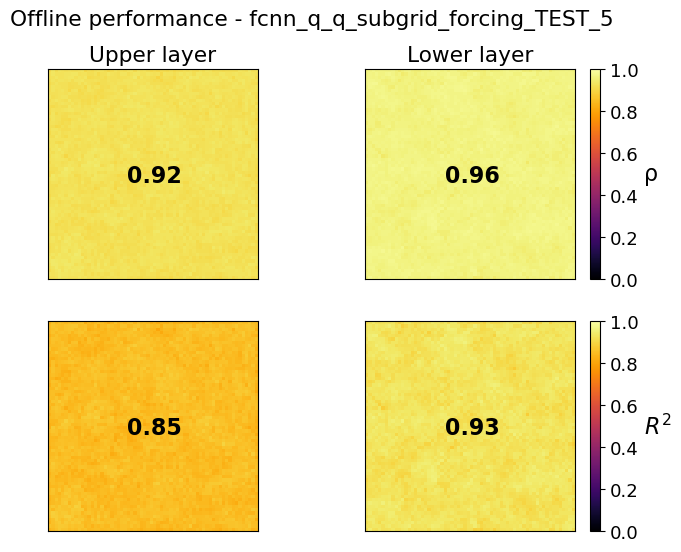

In [19]:
# -- Computing predictions, plotting and saving offline tests results --
#
# Computing the predictions made by the parameterization
offline_pred = FCNN_trained.test_offline(test_ALR)

# Plotting the results
fig = plt.figure(figsize = (8, 6))

# Adding title
plt.suptitle(f"Offline performance - {loading_folder}")

for z in [0, 1]:
    plt.subplot(2, 2, z + 1, title = f"{['Upper','Lower'][z]} layer")
    imshow(offline_pred.q_subgrid_forcing_spatial_correlation.isel(lev = z)) if target_var == 0 else \
    imshow(offline_pred.q_forcing_total_spatial_correlation.isel(lev = z))
    if z: colorbar("ρ")
    
for z in [0, 1]:
    plt.subplot(2, 2, z + 3)
    imshow(offline_pred.q_subgrid_forcing_spatial_skill.isel(lev = z)) if target_var == 0 else \
    imshow(offline_pred.q_forcing_total_spatial_skill.isel(lev = z))
    if z: colorbar("$R^2$")

# Complete path to save the figure
offline_path = f"../datasets/{loading_folder_data}/offline/"

# Check if image folder exists
if not os.path.exists(offline_path):
    os.makedirs(offline_path)

# Save the figure
fig.savefig(offline_path + f"/{loading_folder}.png")

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>Online (GPU)</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">

In this section, the goal is to test the **ability of the network to make good predictions** by checking the **physics** of the results.

In [ ]:
# -- Computing predictions --
#
online_preds = FCNN_trained.run_online(sampling_freq=24 * 26, **getDatasetAttributes(test_LR))

# Storing simulation results
online_simulation = [(test_HR, 'High-res'),(test_LR, 'Low-res'), (online_preds,'Low-res + FCNN')]

In [ ]:
# -- Energy Budget Comparison --
fig = energy_budget_figure(online_simulation)
fig.suptitle(f"Energy Budget Comparison - {loading_folder} - {loading_folder_data}")
plt.tight_layout()
plt.show()

# Complete path to save the figure
online_path = f"../datasets/{loading_folder_data}/online/"

# Check if image folder exists
if not os.path.exists(online_path):
    os.makedirs(online_path)

# Save the figure
fig.savefig(online_path + f"/energy_budget.png")

In [ ]:
# -- Upper Potential Vorticity Comparison --
fig = plt.figure(figsize = (13, 4))
plt.suptitle(f"Upper Potential Vorticity - {loading_folder} - {loading_folder_data}")

for i, (m, label) in enumerate(online_simulation):
    plt.subplot(1, 3, i + 1, title = label)
    plt.imshow(m.q.isel(lev = 0, time = -1), cmap='bwr', vmin = -3e-5, vmax = 3e-5)
plt.colorbar(label="Upper PV [$s^{-1}$]")
plt.tight_layout()

# Complete path to save the figure
online_path = f"../datasets/{loading_folder_data}/online/"

# Check if image folder exists
if not os.path.exists(online_path):
    os.makedirs(online_path)

# Save the figure
fig.savefig(online_path + f"/PV_comparison.png")

In [ ]:
# -- Vorticity Distribution Comparison (Quasi Steady-State) --
fig = fig = plt.figure()
plt.title(f"Differences in distributions of quasi-steady $q_1$ - {loading_folder} - {loading_folder_data}")
for i, (m, label) in enumerate(online_simulation):
    data = m.q.isel(lev = 0, time = slice(-20, None)).data.ravel()
    dist = gaussian_kde(data)
    x = np.linspace(*np.percentile(data, [1,99]), 1000)
    plt.plot(x, dist(x), label = label, lw = 3, ls = ('--' if 'FCNN' in label else '-'))
plt.legend()
plt.xlabel("Upper PV [$s^{-1}$]")
plt.ylabel("Probability density")
plt.tight_layout()

# Complete path to save the figure
online_path = f"../datasets/{loading_folder_data}/online/"

# Check if image folder exists
if not os.path.exists(online_path):
    os.makedirs(online_path)

# Save the figure
fig.savefig(online_path + f"/distribution.png")

<hr style="color:#5A7D9F; width: 100%;" align="left">
<p align="center">
	<b style="font-size:1vw;">
	<center>Simulation Memory Calculator</center>
	</b>
</p>
<hr style="color:#5A7D9F; width: 100%;" align="left">

In [ ]:
# Sampling rate of the 10 years simulation
SMC_sr = 50

# Number of samples for training
SMC_training = 0.7

# -------------------------------------------------
#
# Computing number of training and test samples
SMC_training_samples = 365 * 10 * 24 / SMC_sr * SMC_training
SMC_test_samples     = 365 * 10 * 24 / SMC_sr * (1 - SMC_training)

# Space needed for each type of sample
memory_HR = 17291/2355
memory_LR = 2779/2355

# Memory Space Needed
Space_needed = (SMC_training_samples + SMC_test_samples) * (memory_HR + memory_LR)

# Displaying information 
print(f"Total samples    = {SMC_training_samples + SMC_test_samples}")
print(f"Training samples = {SMC_training_samples}")
print(f"Test samples     = {SMC_test_samples}")
print(f"Space for sim.   = {Space_needed/1000} [GB]")
